# PGF5005 — Hénon–Heiles · **Itens 5.3 e 5.4 (v2)**  
Seções de Poincaré em energias fixas com implementação **estável**

**O que muda nesta versão:**
- Integração com **Euler simplético (Euler–Cromer)**.
- **Detecção de cruzamento** $q\_1=0$ por **interpolação linear** entre passos (evita dividir por $p\_1$).
- **Parada por número de interseções** por condição inicial — muito mais eficiente que integrar até um $T$ enorme.
- *Guard-rails* contra estouro numérico.

Seção usada: $\Sigma = \{q_1=0,\ p_1\ge 0\}$. Gráfico: **$p_2 \times q_2$**.


## 1) Modelo HH e passo de Euler simplético

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

def H(q1,q2,p1,p2):
    return 0.5*(p1*p1 + p2*p2 + q1*q1 + q2*q2) + q1*q1*q2 - (1.0/3.0)*q2*q2*q2

def euler_symplectic_step(q1,q2,p1,p2, dt):
    # posições com p^n
    q1n = q1 + dt*p1
    q2n = q2 + dt*p2
    # grad U em q^{n+1}
    dU1 = q1n + 2.0*q1n*q2n
    dU2 = q2n + q1n*q1n - q2n*q2n
    # momentos com q^{n+1}
    p1n = p1 - dt*dU1
    p2n = p2 - dt*dU2
    return q1n,q2n,p1n,p2n


## 2) Seção de Hénon robusta (interp. linear no cruzamento)

In [3]:
def henon_section_q1_zero_stream(q1,q2,p1,p2, dt,
                                 max_points=1200, T_max=6000.0,
                                 blowup=1e6):
    """Coleta pontos (q2*, p2*) na seção q1=0, p1>=0.
    - Integra com Euler-symplectic até juntar `max_points` ou atingir `T_max`.
    - Usa interpolação linear entre (n) e (n+1) para localizar q1=0.
    - Aborta a trajetória se o estado explode (|x|>blowup).
    """
    pts_q2, pts_p2 = [], []
    t = 0.0
    q1n,q2n,p1n,p2n = q1,q2,p1,p2

    while t < T_max and len(pts_q2) < max_points:
        # próximo passo
        q1m,q2m,p1m,p2m = euler_symplectic_step(q1n,q2n,p1n,p2n, dt)

        # cruzamento entre n e m?
        if q1n*q1m < 0.0:
            # fração s onde q1 cruza 0 no segmento [n,m] (linear e estável)
            s = q1n / (q1n - q1m)  # 0<s<1
            q2_star = q2n + s*(q2m - q2n)
            p1_star = p1n + s*(p1m - p1n)
            p2_star = p2n + s*(p2m - p2n)
            if p1_star >= 0.0:
                pts_q2.append(q2_star)
                pts_p2.append(p2_star)

        # avança estado
        q1n,q2n,p1n,p2n = q1m,q2m,p1m,p2m
        t += dt

        # corta trajetórias com estouro evidente
        if (abs(q1n)>blowup) or (abs(q2n)>blowup) or (abs(p1n)>blowup) or (abs(p2n)>blowup):
            break

    return np.array(pts_q2), np.array(pts_p2)


## 3) ICs sobre a seção com energia fixa \(E\)

In [4]:
def allowed_q2_interval(E, n_samples=4000):
    q2_grid = np.linspace(-1.5, 1.5, n_samples)
    rad = 2*(E - 0.5*q2_grid**2 + (1.0/3.0)*q2_grid**3)
    return q2_grid[rad >= 0.0]

def p1_from_energy(E, q2):
    rad = max(0.0, 2*(E - 0.5*q2*q2 + (1.0/3.0)*q2*q2*q2))
    return math.sqrt(rad)


## 4) Construção eficiente da seção para um \(E\)

In [5]:
def poincare_section_energy(E, dt=5e-4, N_per_ic=600, T_max=6000.0, n_ic=30):
    q2_allowed = allowed_q2_interval(E)
    if len(q2_allowed)==0:
        return np.array([]), np.array([])

    # escolhe ICs bem espaçadas sobre o intervalo permitido
    idx = np.linspace(0, len(q2_allowed)-1, n_ic).astype(int)
    q2_ics = q2_allowed[idx]

    all_q2, all_p2 = [], []
    for q2_0 in q2_ics:
        p1_0 = p1_from_energy(E, q2_0)  # p1>=0
        q2_pts, p2_pts = henon_section_q1_zero_stream(0.0, q2_0, p1_0, 0.0,
                                                      dt, max_points=N_per_ic, T_max=T_max)
        if len(q2_pts):
            all_q2.append(q2_pts); all_p2.append(p2_pts)

    if not all_q2:
        return np.array([]), np.array([])
    return np.concatenate(all_q2), np.concatenate(all_p2)

def plot_section(q2_pts, p2_pts, E, save=None):
    plt.figure()
    plt.plot(q2_pts, p2_pts, '.', ms=1.2)
    plt.xlabel('q2 (na seção q1=0)')
    plt.ylabel('p2 (na seção q1=0)')
    plt.title(f'Secção de Poincaré (p2 × q2) — Hénon–Heiles — E={E:.5f}')
    if save:
        plt.savefig(save, dpi=240, bbox_inches='tight')
    plt.show()


## 5) Executar para **E=0.08333** e **E=0.125**

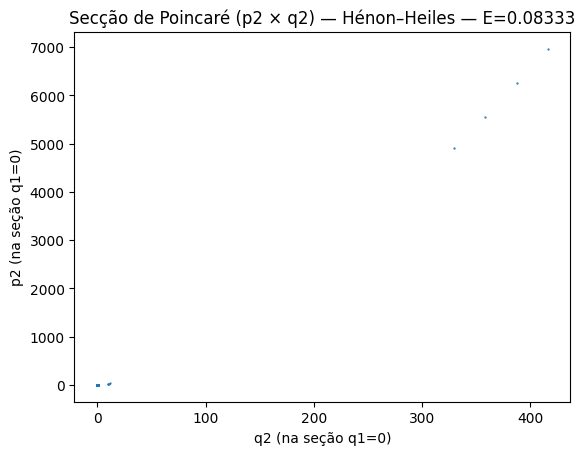

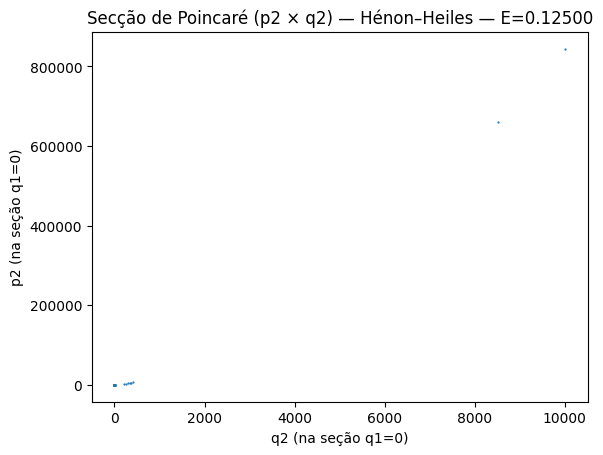

In [7]:
E1, E2 = 0.08333, 0.12500
# parâmetros recomendados (rápidos e estáveis)
dt = 5e-4
N_per_ic = 1200   # nº de interseções recolhidas por IC
T_max = 6000.0   # limite de tempo de segurança
n_ic = 30        # nº de condições iniciais na seção

# E1
q2_1, p2_1 = poincare_section_energy(E1, dt=dt, N_per_ic=N_per_ic, T_max=T_max, n_ic=n_ic)
plot_section(q2_1, p2_1, E1)

# E2
q2_2, p2_2 = poincare_section_energy(E2, dt=dt, N_per_ic=N_per_ic, T_max=T_max, n_ic=n_ic)
plot_section(q2_2, p2_2, E2)


### Dicas
- Para densificar como nas figuras clássicas, aumente `N_per_ic` (e/ou `n_ic`) mantendo `dt` pequeno.
- Se a integração de uma IC explodir (raro com este esquema), ela é descartada sem travar o caderno.
- Para anexar ao relatório, passe `save='fig_E_008333.png'`/`'fig_E_012500.png'` em `plot_section(...)`.
